In [26]:
import torch
from torch.utils.data import DataLoader,TensorDataset
from torch import nn
from torch.optim import lr_scheduler
import torch.optim as optim


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import math
from mpl_toolkits.mplot3d import Axes3D
from random import uniform




Integrating Adversarial Autoencoders (AAEs) into my fraud detection system could significantly enhance its performance. Currently, my model has a strong recall of 88.95%, effectively detecting a high percentage of true anomalies, but precision stands at 91.69%, indicating some room for improvement. The F1 score of 90.30% shows a good balance, but increasing precision could further boost the model's effectiveness.

By leveraging AAEs, I expect to  address these issues in several ways. The AAE’s ability to generate synthetic fraudulent transactions will help balance my dataset, which is especially useful if the number of fraudulent transactions is limited. This data augmentation will improve the model’s training and help reduce false positives.

Furthermore, AAEs combine autoencoder and adversarial training to enhance anomaly detection. The autoencoder learns to reconstruct normal data, while the adversarial component improves the distinction between real and synthetic data. This dual approach allows for more accurate anomaly classification, which can refine the threshold for detecting anomalies and improve precision.

AAEs also offer advanced feature extraction and representation learning, which can enhance the autoencoder’s ability to identify subtle anomalies. Additionally, AAEs can continuously adapt to new data, ensuring that the anomaly detection system remains effective as transaction patterns evolve.

To implement AAEs, I’ll start by preparing my data with both normal and fraudulent transactions. After training the autoencoder, I'll use the AAE to generate synthetic data and refine anomaly detection. This approach should lead to better precision and overall performance in my fraud detection system

In [6]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [11]:
main_path = "/home/hernan/Pytorch_scripts/Autoencoders/credit_card/creditcard_2023.csv"  

In [12]:
df = pd.read_csv(main_path)

In [38]:

# Normalize the "Amount" column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))


# Extract features and labels from the entire dataset
X = df.drop(["id", "Class"], axis=1).values  
y = df["Class"].values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Filter non-fraudulent data (Class = 0) from the training set
X_train = X_train[y_train == 0]
y_train = y_train[y_train == 0]

# Display dimensions to verify
print("Dimensions of X_train_non_fraud:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train_non_fraud:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

# #Standarize data based on mean & std of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train -mean)/std
X_test = (X_test -mean)/std

# Pass the data to tensors

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)  
y_test_tensor = torch.LongTensor(y_test)    


# Create DataLoader to handle data in batches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


bs = 840
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=8)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=8)


Dimensions of X_train_non_fraud: (255816, 29)
Dimensions of X_test: (56863, 29)
Dimensions of y_train_non_fraud: (255816,)
Dimensions of y_test: (56863,)


<bound method Axes3D.set of <Axes3D: xlabel='PCA Component 1', ylabel='PCA Component 2', zlabel='PCA Component 3'>>

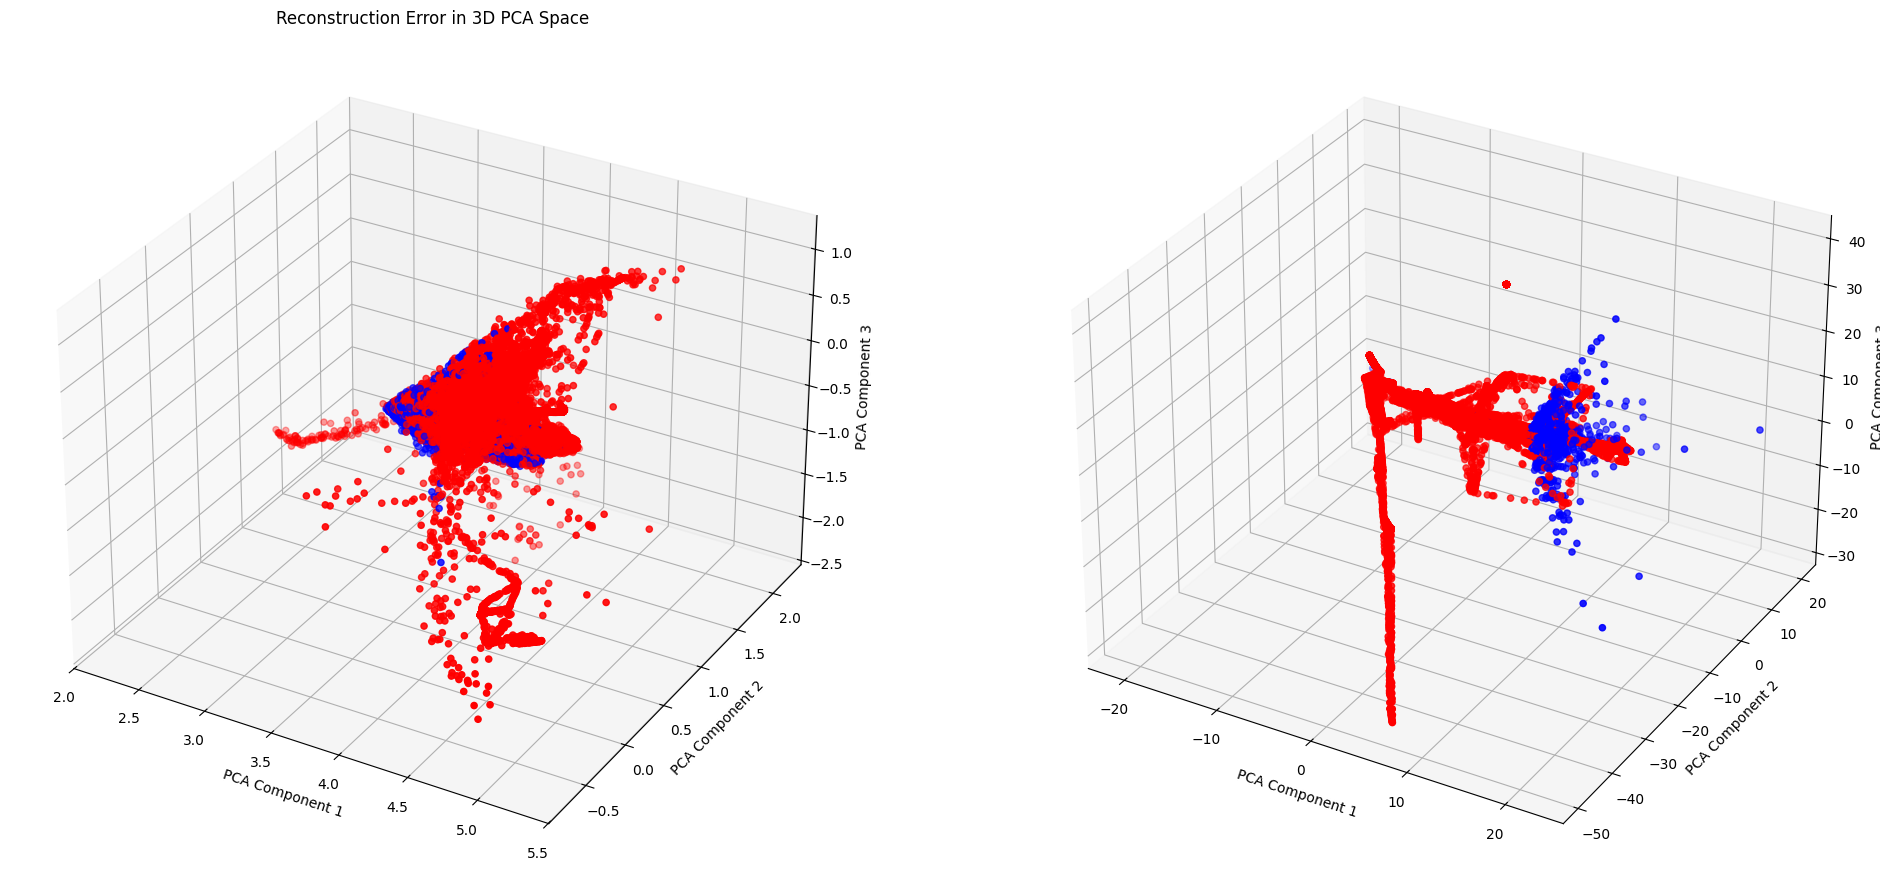

In [32]:

# Evaluate the model and visualize in PCA space
autoencoder.eval()
discriminator.eval()

reconstructed_data = []
original_data = []
anomalies = []

with torch.no_grad():
    for batch in test_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device)
        
        recon_batch = autoencoder(X_batch)
        reconstructed_data.append(recon_batch.cpu().numpy())
        original_data.append(X_batch.cpu().numpy())

        reconstruction_error = torch.mean((recon_batch - X_batch) ** 2, dim=1)
        anomalies.extend((reconstruction_error > threshold).cpu().numpy())

reconstructed_data = np.concatenate(reconstructed_data, axis=0)
original_data = np.concatenate(original_data, axis=0)

# PCA reduction
pca = PCA(n_components=3)
original_data_reduced = pca.fit_transform(original_data)
reconstructed_data_reduced = pca.transform(reconstructed_data)

# Colors for the points: 'r' for anomalies and 'b' for normals
colors_anomalies = ['r' if x else 'b' for x in anomalies]
colors_fraud = ['r' if x == 1 else 'b' for x in y_test]

# Configure the figure and axes
fig = plt.figure(figsize=(24, 12))

# First plot: Reconstruction Error
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(reconstructed_data_reduced[:, 0], reconstructed_data_reduced[:, 1], reconstructed_data_reduced[:, 2],
                       c=colors_anomalies, marker='o')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('Reconstruction Error in 3D PCA Space')

# Second plot: Fraud Detection
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(original_data_reduced[:, 0], original_data_reduced[:, 1], original_data_reduced[:, 2],
                       c=colors_fraud, marker='o')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('PCA Component 3')
ax2.set


In [41]:

# Define the Autoencoder with GAN
##model definition
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(29, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, latent_dim)  # Latent dimension
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),  # Changed to ReLU for decoder
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 29),
            nn.Tanh()  # Changed from Sigmoid to Tanh for reconstruction
        )
    
  
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)


# Normalize the "Amount" column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))


# Extract features and labels from the entire dataset
X = df.drop(["id", "Class"], axis=1).values  
y = df["Class"].values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Filter non-fraudulent data (Class = 0) from the training set
X_train = X_train[y_train == 0]
y_train = y_train[y_train == 0]

# Display dimensions to verify
print("Dimensions of X_train_non_fraud:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train_non_fraud:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)

# #Standarize data based on mean & std of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train -mean)/std
X_test = (X_test -mean)/std

# Pass the data to tensors

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)  
y_test_tensor = torch.LongTensor(y_test)    


# Create DataLoader to handle data in batches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


bs = 1024
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=bs,
    shuffle=True,
    num_workers=8)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=8)

# Hyperparameters
latent_dim = 32
LR = 0.001
NUM_EPOCHS = 100

# Initialize models
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)
discriminator = Discriminator(latent_dim=latent_dim).to(device)

# Loss functions and optimizers
criterion_recon = nn.MSELoss()
criterion_adv = nn.BCELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=LR)
optimizer_d = optim.Adam(discriminator.parameters(), lr=LR)

# Training loop
for epoch in range(NUM_EPOCHS):
    autoencoder.train()
    discriminator.train()
    train_loss = 0
    num_samples = 0
    d_loss_total = 0

    if epoch % 2 == 0:
        # Train Discriminator
        for batch in train_loader:
            X_batch, _ = batch
            X_batch = X_batch.to(device)
            batch_size = X_batch.size(0)

            optimizer_d.zero_grad()

            # Real and fake labels
            real_z = torch.randn(batch_size, latent_dim).to(device)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Discriminator on real data
            real_validity = discriminator(real_z)
            d_loss_real = criterion_adv(real_validity, real_labels)

            # Discriminator on fake data from autoencoder
            fake_z = autoencoder.encoder(X_batch)
            fake_validity = discriminator(fake_z)
            d_loss_fake = criterion_adv(fake_validity, fake_labels)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()
            d_loss_total += d_loss.item() * batch_size

        avg_d_loss = d_loss_total / len(train_loader.dataset)  # Average per sample
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Discriminator Loss: {avg_d_loss:.4f}')

    else:
        # Train Autoencoder (Generator)
        for batch in train_loader:
            X_batch, _ = batch
            X_batch = X_batch.to(device)
            batch_size = X_batch.size(0)

            optimizer_ae.zero_grad()

            # Autoencoder reconstruction
            recon_data = autoencoder(X_batch)
            recon_loss = criterion_recon(recon_data, X_batch)

            # Adversarial loss
            fake_z = autoencoder.encoder(X_batch)
            validity = discriminator(fake_z)

            # Use the same label shape as the discriminator output
            real_labels = torch.ones(batch_size, 1).to(device)
            adv_loss = criterion_adv(validity, real_labels)

            # Total autoencoder loss
            ae_loss = recon_loss + adv_loss
            ae_loss.backward()
            optimizer_ae.step()

            train_loss += ae_loss.item() * batch_size
            num_samples += batch_size

        avg_train_loss = train_loss / num_samples
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_train_loss:.4f}')




Dimensions of X_train_non_fraud: (255816, 29)
Dimensions of X_test: (56863, 29)
Dimensions of y_train_non_fraud: (255816,)
Dimensions of y_test: (56863,)
Epoch [1/100], Discriminator Loss: 0.2387
Epoch [2/100], Loss: 1.1558
Epoch [3/100], Discriminator Loss: 0.2158
Epoch [4/100], Loss: 0.9133
Epoch [5/100], Discriminator Loss: 0.4092
Epoch [6/100], Loss: 0.8429
Epoch [7/100], Discriminator Loss: 0.3632
Epoch [8/100], Loss: 0.8034
Epoch [9/100], Discriminator Loss: 0.4613
Epoch [10/100], Loss: 0.7702
Epoch [11/100], Discriminator Loss: 0.5180
Epoch [12/100], Loss: 0.7075
Epoch [13/100], Discriminator Loss: 0.4610
Epoch [14/100], Loss: 0.7354
Epoch [15/100], Discriminator Loss: 0.4816
Epoch [16/100], Loss: 0.7240
Epoch [17/100], Discriminator Loss: 0.5130
Epoch [18/100], Loss: 0.6783
Epoch [19/100], Discriminator Loss: 0.4631
Epoch [20/100], Loss: 0.6739
Epoch [21/100], Discriminator Loss: 0.5961
Epoch [22/100], Loss: 0.6928
Epoch [23/100], Discriminator Loss: 0.5314
Epoch [24/100], Loss

Training reconstruction loss: 0.3978
Set threshold: 0.5967
Precision: 0.9249
Recall: 0.8922
F1 Score: 0.9083
Number of anomalies detected: 27362 vs Number of anomalies: 28364


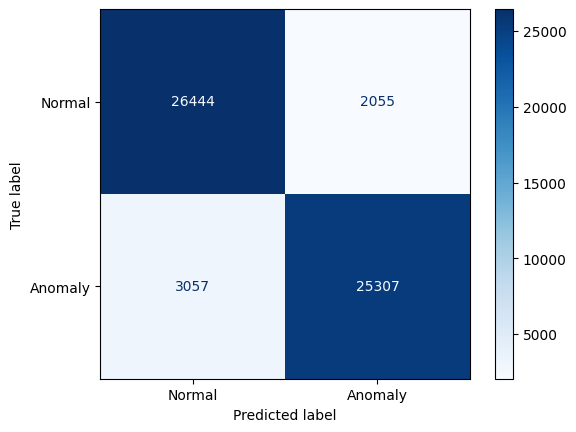

In [47]:

# Count the number of anomalies in the test set
num_anomalies_test = np.sum(y_test == 1)

# Define the loss function
criterion = nn.MSELoss()

# Set the model to evaluation mode
autoencoder.eval()

# Calculate reconstruction error on the training set
with torch.no_grad():
    X_train_tensor = X_train_tensor.to(device)
    reconstructions_train = autoencoder(X_train_tensor)
    train_loss = criterion(reconstructions_train, X_train_tensor)

print(f'Training reconstruction loss: {train_loss.item():.4f}')

# Set threshold as a multiple of the training set loss
threshold = train_loss.item() * 1.5
print(f'Set threshold: {threshold:.4f}')

# Detect anomalies on the test set
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    reconstructions_test = autoencoder(X_test_tensor)
    test_loss = torch.mean((reconstructions_test - X_test_tensor) ** 2, dim=1).cpu().numpy()

# Create binary predictions based on the threshold
y_pred_binary = (test_loss > threshold).astype(int)

# Evaluate the model
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
num_anomalies_detected = np.sum(y_pred_binary)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Number of anomalies detected: {num_anomalies_detected} vs Number of anomalies: {num_anomalies_test}')

# Convert true labels to binary (1 for anomaly, 0 for normal)
y_true_binary = (y_test == 1).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_binary)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues', values_format='d')
plt.show()


<bound method Axes3D.set of <Axes3D: xlabel='PCA Component 1', ylabel='PCA Component 2', zlabel='PCA Component 3'>>

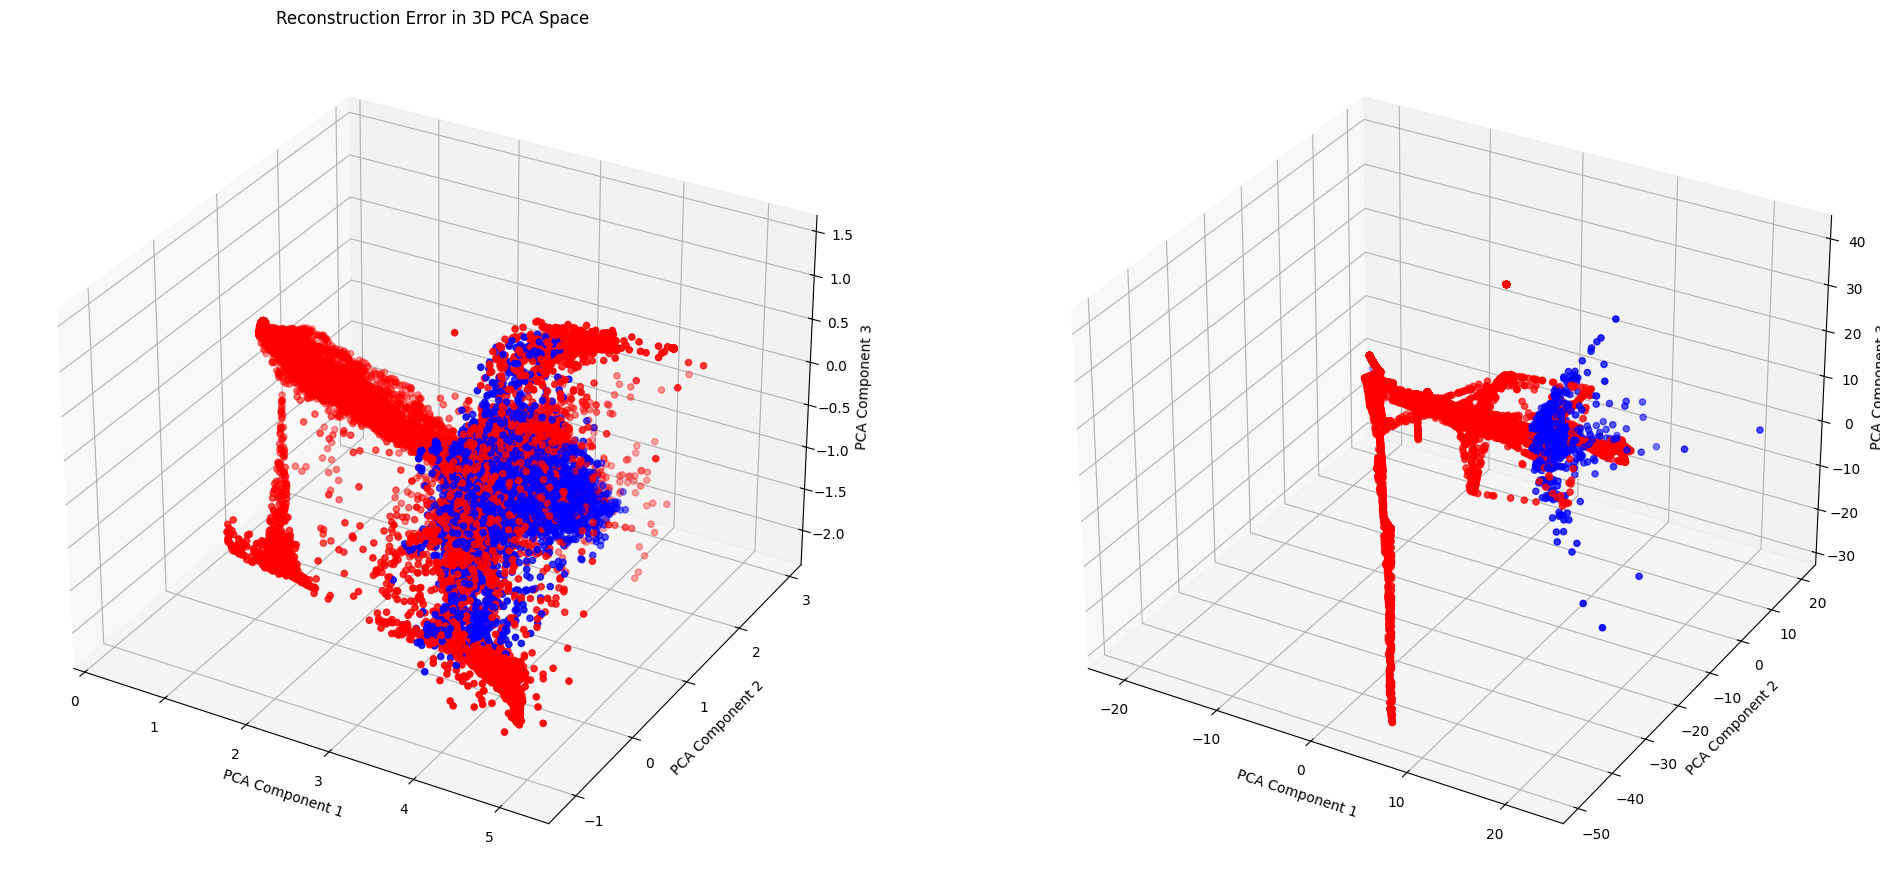

In [48]:

# Evaluate the model and visualize in PCA space
autoencoder.eval()
discriminator.eval()

reconstructed_data = []
original_data = []
anomalies = []

with torch.no_grad():
    for batch in test_loader:
        X_batch, _ = batch
        X_batch = X_batch.to(device)
        
        recon_batch = autoencoder(X_batch)
        reconstructed_data.append(recon_batch.cpu().numpy())
        original_data.append(X_batch.cpu().numpy())

        reconstruction_error = torch.mean((recon_batch - X_batch) ** 2, dim=1)
        anomalies.extend((reconstruction_error > threshold).cpu().numpy())

reconstructed_data = np.concatenate(reconstructed_data, axis=0)
original_data = np.concatenate(original_data, axis=0)

# PCA reduction
pca = PCA(n_components=3)
original_data_reduced = pca.fit_transform(original_data)
reconstructed_data_reduced = pca.transform(reconstructed_data)

# Colors for the points: 'r' for anomalies and 'b' for normals
colors_anomalies = ['r' if x else 'b' for x in anomalies]
colors_fraud = ['r' if x == 1 else 'b' for x in y_test]

# Configure the figure and axes
fig = plt.figure(figsize=(24, 12))

# First plot: Reconstruction Error
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(reconstructed_data_reduced[:, 0], reconstructed_data_reduced[:, 1], reconstructed_data_reduced[:, 2],
                       c=colors_anomalies, marker='o')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.set_title('Reconstruction Error in 3D PCA Space')

# Second plot: Fraud Detection
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(original_data_reduced[:, 0], original_data_reduced[:, 1], original_data_reduced[:, 2],
                       c=colors_fraud, marker='o')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_zlabel('PCA Component 3')
ax2.set
